## Extract data
The 'eda' database is as postgres schema hosted on Amazon AWS. There are two tables:
1. 'king_county_house_sales' (21597)
1. 'king_county_house_details' (21420)

According to the Entity Relationship Diagram generated by DBeaver, there is a 1:1 relationship between the two tables. The table 'king_county_house_sales' does not include any WHERE house_id ISNULL but there could be 'king_county_house_details' for which no sale is recorded in 'king_county_house_sales'. A LEFT JOIN ensures that we get all sales.

DBeaver has the facility to:
1. Expand column from * via Control-Space
1. Format SQL

Expanding the columns from kchd.* allows id to be renamed AS house_id rather than perform this in pandas later. Other simple changes could also be performed early in the process.

```df.rename({'id': 'house_id'}, axis=1, inplace=True)```


In [16]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

#read the database string from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

#import the data to a pandas dataframe
query_string = '''
SELECT
	kchs.date,
	kchs.price,
	kchs.id AS sale_id,
	kchd.id AS house_id,
	kchd.bedrooms,
	kchd.bathrooms,
	kchd.sqft_living,
	kchd.sqft_lot,
	kchd.floors,
	kchd.waterfront,
	kchd.view,
	kchd.condition,
	kchd.grade,
	kchd.sqft_above,
	kchd.sqft_basement,
	kchd.yr_built,
	kchd.yr_renovated,
	kchd.zipcode,
	kchd.lat,
	kchd.long,
	kchd.sqft_living15,
	kchd.sqft_lot15
FROM
	eda.king_county_house_sales kchs
LEFT JOIN eda.king_county_house_details kchd ON
	kchd.id = kchs.house_id
'''
df = pd.read_sql(query_string, db)

#export the data to a csv-file
df.to_csv('data/house_client.csv', index=False)

## Read data
Now that we have a local .csv file, we can come back to this cell to make changes to the EDA without going back to the database each time.

In [3]:
import pandas as pd
df = pd.read_csv('data/house_client.csv', parse_dates=['date'])

## Exploratory Data Analysis
Now that we have an intitial DataFame, we can get begin to expore the data:

1. What are the potential issues with the data (e.g., duplicates, typos)?
1. How prevalent are missing values?
1. What are the central tendencies and spread of data?
1. How can the data be visually represented?
1. Are there extreme values that may impact analysis?
1. How do variables relate to each other?
1. Are there transformations to improve analysis?

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,1,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,2,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,3,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,770.0,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,4,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,1050.0,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,5,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,1680.0,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0


## Potential Issues

1. The only categorical data seems to be the 'grade' and 'condition' features.
1. The feature 'view' is a boolean value.
1. The max for the 'bedrooms' feature at 33 seems a lot.
1. The max for the 'sqft_living' feature at 13540 high.
1. What does it mean to have .5 on the 'floors' feature?
1. The 'yr_renovated' feature seems to have corrupted data e.g. 20150
1. sqft_above + sqft_basement = sqft_living
1. grade and sqft_above see to match sometimes...
1. lat and long taken as individual features lead to poor correlations

According to [King County's Residential Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r):

1. 'grade' AKA BUILDING GRADE is a scale from 1-13 where 1 is low and 13 is high.
1. 'condition AKA BUILDING CONDITION is a scale from 1-5 where 1 is 'poor' and 5 is 'very good'

Appraisals for neighbourhoods can be based on:

- **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
- **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
- **view** - Has been viewed

In [5]:
building_condition = {1: 'Poor', 2: 'Fair', 3: 'Average', 4: 'Good', 5: 'Very Good'}
# 'grade' 1-5 are below current building code, 6-9 are typical in size and quality, 10-13 are larger and exceptional

df.isnull().sum().where(lambda x: x != 0).dropna(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   sale_id        21597 non-null  int64         
 3   house_id       21597 non-null  int64         
 4   bedrooms       21597 non-null  float64       
 5   bathrooms      21597 non-null  float64       
 6   sqft_living    21597 non-null  float64       
 7   sqft_lot       21597 non-null  float64       
 8   floors         21597 non-null  float64       
 9   waterfront     19206 non-null  float64       
 10  view           21534 non-null  float64       
 11  condition      21597 non-null  int64         
 12  grade          21597 non-null  int64         
 13  sqft_above     21597 non-null  float64       
 14  sqft_basement  21145 non-null  float64       
 15  yr_built       2159

(waterfront       2391.0
 view               63.0
 sqft_basement     452.0
 yr_renovated     3848.0
 dtype: float64,
 None)

In [6]:
import pygeohash as gh

# precision 7 equates to 152.9m x 152.4m which is precise enough to correlate with sale_id?
# precision 6 equates to 1.2km x 609.4m
# see https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html
df['geohash'] = df.apply(lambda x: gh.encode(x.lat, x.long, precision=6), axis=1)
df['geohash_proxy'] = pd.factorize(df['geohash'])[0]

df['sqft_price'] = df.apply(lambda x: round(x.price / x.sqft_living, 2), axis=1)

In [393]:
df.query('bedrooms > 20')

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geohash,geohash_proxy,sqft_price
15856,2014-06-25,640000.0,15857,2402100895,33.0,1.75,1620.0,6000.0,1.0,0.0,0.0,5,7,1040.0,580.0,1947,0.0,98103,47.6878,-122.331,1330.0,4700.0,c23p233,12475,395.06


In [119]:
df.query('sqft_basement == sqft_basement and sqft_above + sqft_basement != sqft_living')

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [349]:
df.query('yr_renovated > 9999 or yr_renovated < yr_built')

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geohash,geohash_proxy,sqrft_price


In [394]:
df.describe()



,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geohash_proxy,sqft_price
count,21597,2.159700e+04,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19206.000000,21534.000000,21597.000000,21597.000000,21597.000000,21145.000000,21597.000000,17749.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,2014-10-29 04:20:38.171968512,5.402966e+05,10799.000000,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007602,0.233863,3.409825,7.657915,1788.596842,291.857224,1970.999676,836.650516,98077.951845,47.560093,-122.213983,1986.620318,12758.283512,7285.449507,264.143328
min,2014-05-02 00:00:00,7.800000e+04,1.000000,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,87.590000
25%,2014-07-22 00:00:00,3.220000e+05,5400.000000,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3257.000000,182.290000
50%,2014-10-16 00:00:00,4.500000e+05,10799.000000,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6953.000000,244.640000
75%,2015-02-17 00:00:00,6.450000e+05,16198.000000,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,11141.000000,318.330000
max,2015-05-27 00:00:00,7.700000e+06,21597.000000,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,20150.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,15691.000000,810.140000
std,NaN,3.673681e+05,6234.661218,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086858,0.765686,0.650546,1.173200,827.759761,442.490863,29.375234,4000.110554,53.513072,0.138552,0.140724,685.230472,27274.441950,4574.384786,110.000060


In [7]:
import numpy as np
import math

df['condition'] = df['condition'].astype('category')
df['grade'] = df['grade'].astype('category')
#df['waterfront'] = df['waterfront'].astype('bool') # converts NaN to False
# yr_renovated needs cleaning
df['yr_renovated'] = df['yr_renovated'].replace(0, np.nan) 
df['yr_renovated'] = df['yr_built'].where(df['yr_renovated'].isna(), other=df['yr_renovated'])
df['yr_renovated'] = df['yr_renovated'].astype('int')

def adjust_year(value):
    digits = int(math.log10(value)) + 1
    dim = digits - 4
    result = int(value / 10**dim)
    return result

df['yr_renovated'] = df['yr_renovated'].apply(adjust_year)
df.isnull().sum().where(lambda x: x != 0).dropna(), df.info()
#df['view'].astype('boolean')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   sale_id        21597 non-null  int64         
 3   house_id       21597 non-null  int64         
 4   bedrooms       21597 non-null  float64       
 5   bathrooms      21597 non-null  float64       
 6   sqft_living    21597 non-null  float64       
 7   sqft_lot       21597 non-null  float64       
 8   floors         21597 non-null  float64       
 9   waterfront     19206 non-null  float64       
 10  view           21534 non-null  float64       
 11  condition      21597 non-null  category      
 12  grade          21597 non-null  category      
 13  sqft_above     21597 non-null  float64       
 14  sqft_basement  21145 non-null  float64       
 15  yr_built       2159

(waterfront       2391.0
 view               63.0
 sqft_basement     452.0
 dtype: float64,
 None)

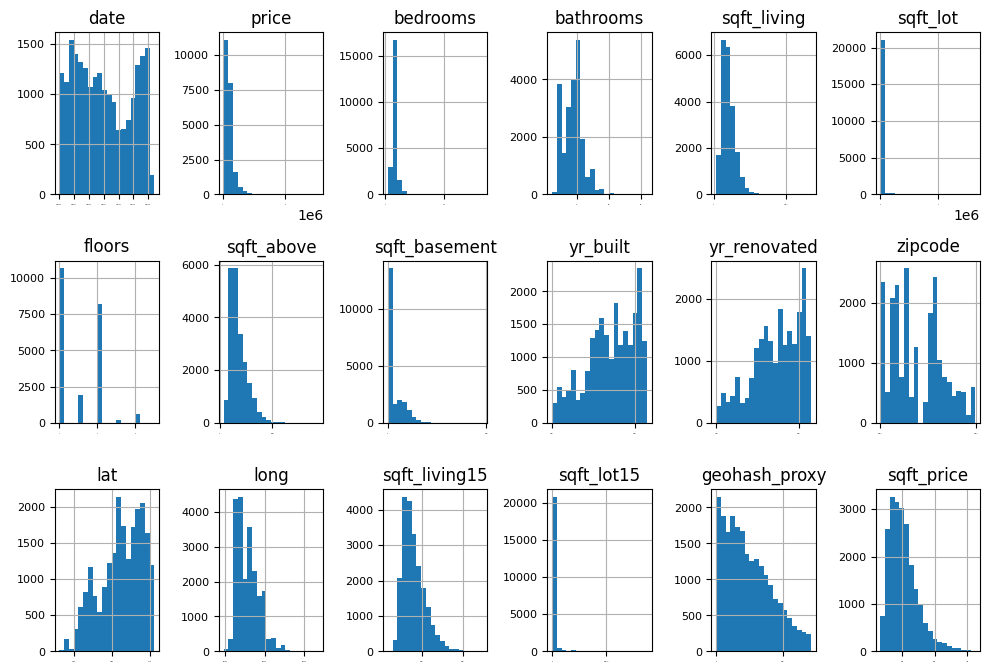

In [8]:
import matplotlib.pyplot as plt

df.drop(columns=['view', 'sale_id', 'house_id', 'waterfront']).hist(sharey=False, layout=(4,6), figsize=(10,9), xlabelsize=0, ylabelsize=8, bins=20,
        histtype='bar', # matplotlib.pyplot.hist
        fill=True # matplotlib.patches.Patch
        )
plt.tight_layout()


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (1).

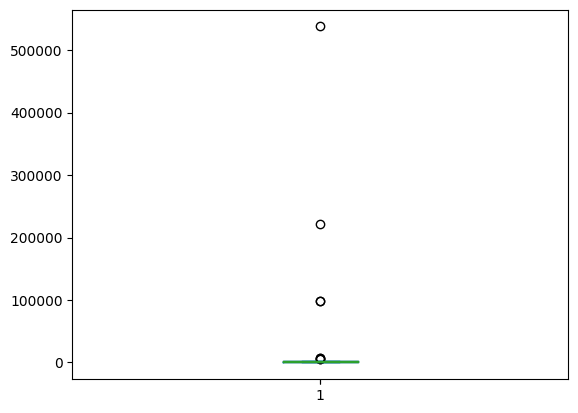

In [402]:
import matplotlib.pyplot as plt

#df['sqft_basement'].dropna().plot(kind='box')

df.drop(columns=['date', 'view', 'sale_id', 'house_id', 'waterfront'])\
    .select_dtypes(include='number')\
    .apply(lambda s: s.dropna().plot(kind='box'), axis=1)

#df.plot.box(df.drop(columns=['view', 'sale_id', 'house_id', 'waterfront']))
#df.drop(columns=['view', 'sale_id', 'house_id', 'waterfront']).boxplot(layout=(4,5), figsize=(10,9),
#        manage_ticks=False, # matplotlib.pyplot.boxplot
#        )
plt.tight_layout()

[Text(0.5, 1.0, 'Pearson Correlation of numerical values')]

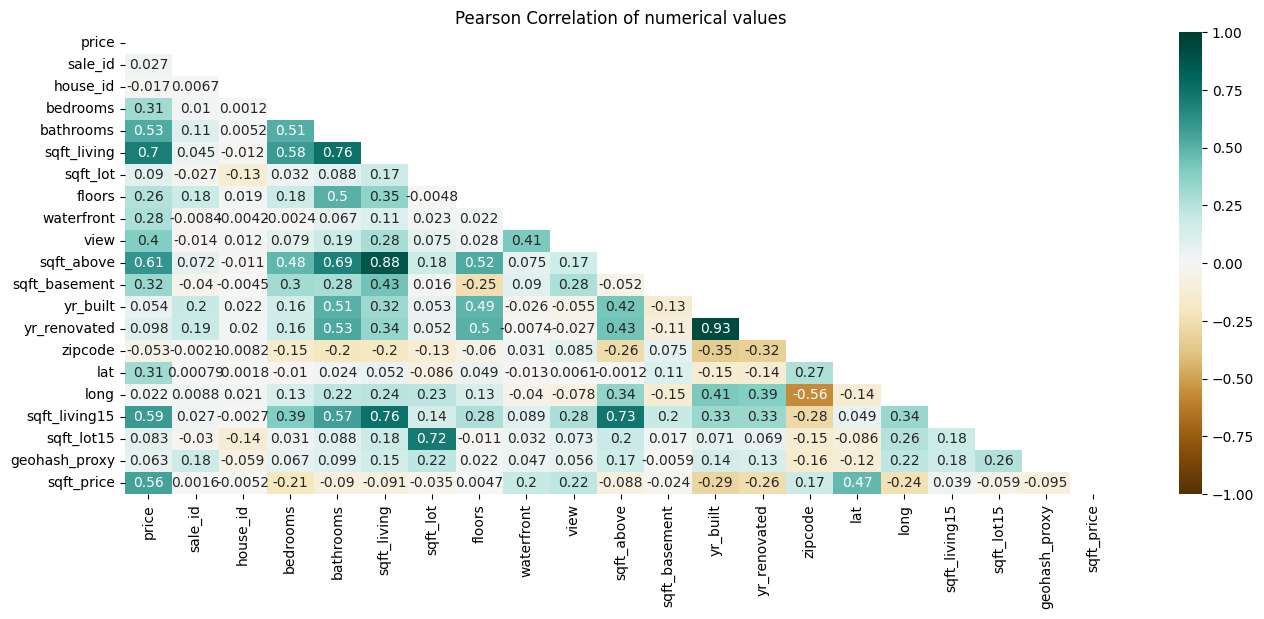

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 6))

corr = df.corr(method='pearson', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            mask=mask,
            vmin=-1, vmax=1,
            annot=True,
            cmap='BrBG',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set(title='Pearson Correlation of numerical values')


1. There is a moderate correlation between 'lat' and 'sqrft_price' indicating a north/south variance.
1. Values that are associated mathematically have strong correlations as expected.
1. There is a moderate correlation between 'condition' and 'yr_built'.
1. The 'price' correlates more strongly with 'grade' than it does 'condition'.

[Text(0.5, 1.0, 'Spearman Correlation of numerical values')]

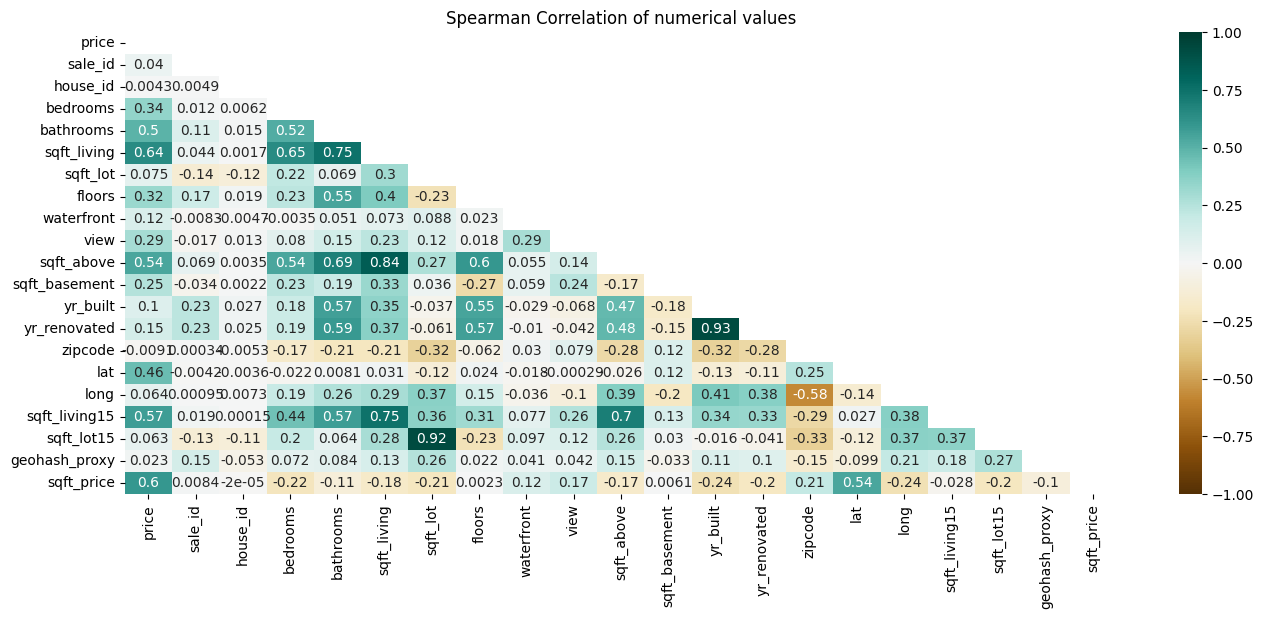

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 6))

corr = df.corr(method='spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            mask=mask,
            vmin=-1, vmax=1,
            annot=True,
            cmap='BrBG',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set(title='Spearman Correlation of numerical values')


In [11]:
corr = df.corr(method='spearman', numeric_only=True)
df_corr = corr['sqft_price'][:-1] # -1 to remove 'sqrft_price'
strongly_correlated = df_corr[abs(df_corr) > 0.5].sort_values(ascending=False)
print("There is/are {} strongly correlated values with sqft_price:\n{}".format(len(strongly_correlated), strongly_correlated))

There is/are 2 strongly correlated values with sqft_price:
price    0.596538
lat      0.540800
Name: sqft_price, dtype: float64


In [27]:
import plotly.express as px

px.density_mapbox(df, lat='lat', lon='long', radius=1, mapbox_style="open-street-map")


## Insights / Hypotheses

1. Poor neighborhoods consist of lower 'grade' AKA BUILDING GRADE houses.
1. Buying & selling in poor neighborhoods brings moderate profit.
1. Prices per sqrft are lower in high-density neighborhoods.



### Poor neighborhoods consist of lower 'grade' AKA BUILDING GRADE houses.
A 'poor neighborhood' is assumed to be one in which the price per sqft is low. To show this, the 'sqft_price' is calculated and compared to 'grade' on a scatter plot.

<Axes: xlabel='grade', ylabel='sqft_price'>

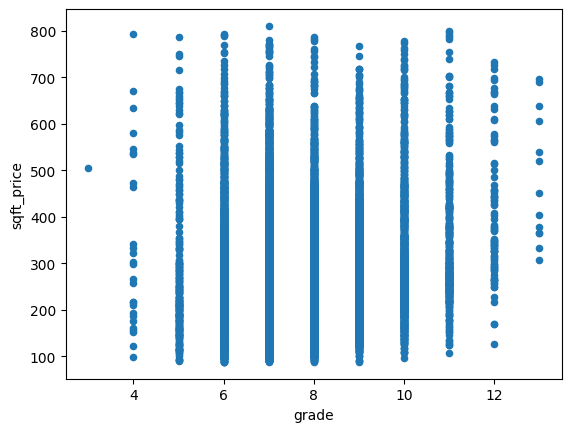

In [30]:
# This discounts somewhat the hypothesis that poor neighborhoods consist of lower 'grade' houses.
df.plot.scatter(y='sqft_price', x='grade')

<Axes: xlabel='lat', ylabel='sqft_price'>

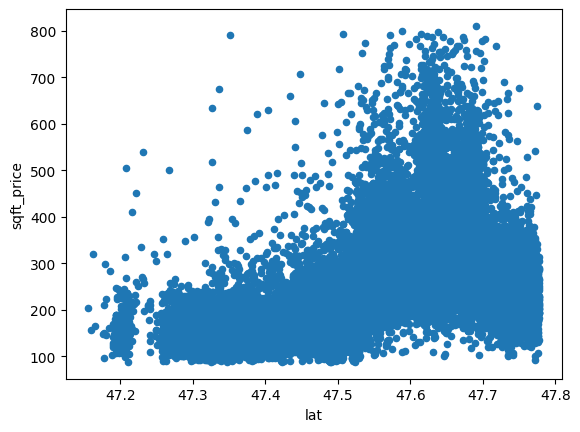

In [31]:
# A better indicator for lower prices AKA poor neighbourhoods is lat < 47.5 (and > 47.8 but there is insufficient data)
df.plot.scatter(y='sqft_price', x='lat')

### Buying & selling in poor neighborhoods brings moderate profit.
With the new assumption for a 'poor neighborhood' where lat < 47.5, we examine the profit potential when buying and selling. It is assumed that the maximum profit is between the min price and max price across 'lat' which can be shown by a box plot.

/var/folders/z7/3j8p82y52y74r52zb1b0w8hr0000gn/T/ipykernel_9913/3229182469.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AttributeError: 'Series' object has no attribute 'set_title'

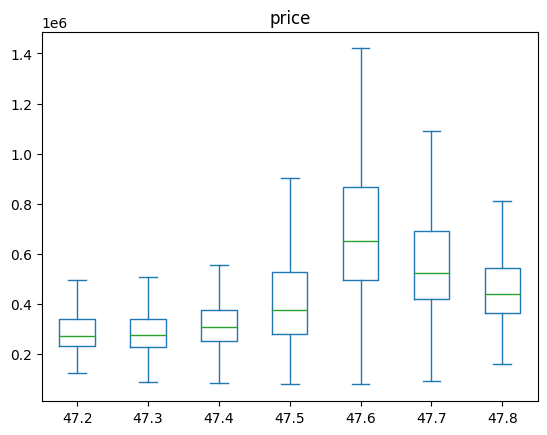

In [68]:
# I want the min and max 
df2 = df[['price', 'lat', 'long', 'condition']]
df2['lat2'] = df2['lat'].apply(lambda x: round(x, 1))
df2.drop(columns=['lat', 'long', 'condition']).plot.box(by='lat2',
             showfliers=False, # matplotlib.pyplot.boxplot
             ).set_title('Price range dependent on latitude')


### Prices per sqft are lower in high-density neighborhoods



## Client

Erin Robinson (Buyer):
1. Invest in poor neighborhood
1. buying & selling
1. costs back + little profit
1. socially responsible



### Buy and sell in the latitude 47.4 +- .1
The density_mapbox below shows the areas that would benefit from being rennovated and would provide a moderate profit.

In [69]:
import plotly.express as px

px.density_mapbox(df2[df2['lat2'] == 47.4], 
                  lat='lat', lon='long', radius=1, mapbox_style="open-street-map")

### Prefer houses that are in poor to average condition
The density_mapbox below shows the houses within 'poor neighbourhoods' that are considered in 1: 'Poor', 2: 'Fair' and 3: 'Average' as indicated by 'condition'. 

In [94]:
import plotly.express as px

# pd.Series([1,2,3]).any()

px.density_mapbox(df2[(df2['lat2'] == 47.4) & (df2['condition'] == 3)], 
                  lat='lat', lon='long', radius=1, mapbox_style="open-street-map")

### Pay attention to budgeting and price
To remain socially responsible, budget to cover costs, aiming for a price point within IQR.